# 📈 05_evaluation.ipynb  
## Compare All Models

### 1. Objective  
Load **all four** saved models, make predictions on their test sets, and compare in **four subplots** plus a summary table.

---

### 2. Load & Predict  
- **RF & MLP:** use `X_test.npy`, `y_test.npy`  
- **ARIMA:** re-forecast prices → returns  
- **LSTM:** use `X_te2.npy`, `y_te2.npy`


```python
import pandas as pd
summary = pd.DataFrame({
  "Model": ["RF","ARIMA","MLP","LSTM"],
  "MAE":   [mae_rf,mae_ar,mae_mlp,mae_lstm],
  "R²":    [r2_rf, r2_ar, r2_mlp, r2_lstm]
})
display(summary.style.format({"MAE":"{:.5f}","R²":"{:.3f}"}))

## Plot predictions vs. actual

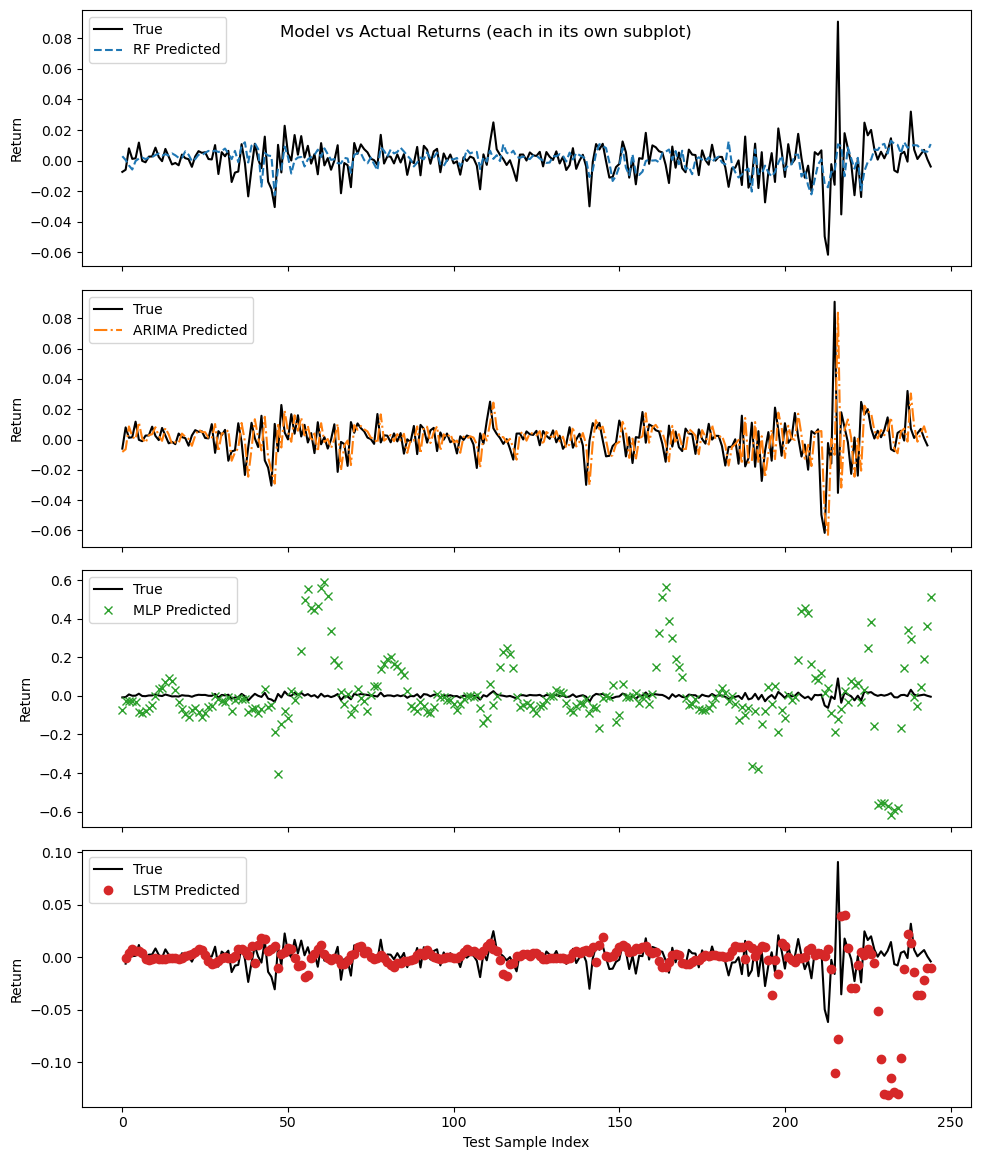

In [4]:
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 1) True vs RF
axes[0].plot(y_test,       label="True", color="black")
axes[0].plot(y_pred_rf,    label="RF Predicted", linestyle="--", color="C0")
axes[0].set_ylabel("Return"); axes[0].legend()

# 2) True vs ARIMA
axes[1].plot(y_test_arima, label="True", color="black")
axes[1].plot(y_pred_arima, label="ARIMA Predicted", linestyle="-.", color="C1")
axes[1].set_ylabel("Return"); axes[1].legend()

# 3) True vs MLP
axes[2].plot(y_test,       label="True", color="black")
axes[2].plot(y_pred_mlp,   label="MLP Predicted", marker="x", linestyle="None", color="C2")
axes[2].set_ylabel("Return"); axes[2].legend()

# 4) True vs LSTM
# Shift index for LSTM so time aligns. 
offset = len(y_test) - len(y_pred_lstm)
axes[3].plot(range(offset, offset+len(y_pred_lstm)), y_te2,        label="True", color="black")
axes[3].plot(range(offset, offset+len(y_pred_lstm)), y_pred_lstm,  label="LSTM Predicted", marker="o", linestyle="None", color="C3")
axes[3].set_ylabel("Return"); axes[3].legend()

axes[-1].set_xlabel("Test Sample Index")
fig.suptitle("Model vs Actual Returns (each in its own subplot)", y=0.95)
plt.tight_layout()
plt.show()


In [10]:
# 6) Build and display summary table (fixed for pandas <1.5)
import numpy             as np
import pandas            as pd
from pathlib             import Path
from sklearn.metrics     import mean_absolute_error, r2_score
import joblib, pickle
from tensorflow.keras.models import load_model

# Reload everything (or assume you already have mae_rf, r2_rf, etc.)
root      = Path().resolve().parent
mdl       = root/"models"
X_test    = np.load(mdl/"X_test.npy")
y_test    = np.load(mdl/"y_test.npy")
X_te2     = np.load(mdl/"X_te2.npy")
y_te2     = np.load(mdl/"y_te2.npy")

rf     = joblib.load(mdl/"rf_model.joblib")
with open(mdl/"arima_model.pkl","rb") as f: arima = pickle.load(f)
mlp    = load_model(mdl/"mlp_model")
lstm   = load_model(mdl/"lstm_model")

# RF warning fix: wrap X_test in a DataFrame with the original feature names
X_test_df = pd.DataFrame(X_test, columns=["rsi","macd"])
y_pred_rf = rf.predict(X_test_df)  # no more warning

y_pred_mlp  = mlp.predict(X_test).flatten()
y_pred_lstm = lstm.predict(X_te2).flatten()

# ARIMA → returns
prices       = pd.read_csv(root/"data"/"raw"/"sp500.csv",
                           index_col="Date", parse_dates=True)["Close"]
n_test       = len(y_test)
predp        = arima.predict(start=len(prices)-n_test, end=len(prices)-1, typ="levels")
y_pred_arima = np.log(predp/predp.shift(1)).dropna().values
y_test_arima = y_test[-len(y_pred_arima):]

# Compute metrics
mae_rf    = mean_absolute_error(y_test,       y_pred_rf)
r2_rf     = r2_score(y_test,       y_pred_rf)

mae_arima = mean_absolute_error(y_test_arima, y_pred_arima)
r2_arima  = r2_score(y_test_arima, y_pred_arima)

mae_mlp   = mean_absolute_error(y_test,       y_pred_mlp)
r2_mlp    = r2_score(y_test,       y_pred_mlp)

mae_lstm  = mean_absolute_error(y_te2,        y_pred_lstm)
r2_lstm   = r2_score(y_te2,        y_pred_lstm)

# Build DataFrame
summary = pd.DataFrame({
    "Model": ["RandomForest", "ARIMA", "MLP", "LSTM"],
    "MAE":   [mae_rf, mae_arima, mae_mlp, mae_lstm],
    "R²":    [r2_rf,  r2_arima,  r2_mlp,  r2_lstm]
})

# Display with proper hiding of index
display(
    summary.style
           .hide(axis="index")
           .format({"MAE":"{:.5f}", "R²":"{:.3f}"})
           .set_caption("📊 Model Performance Summary")
)


8/8 [==============================] - 0s 3ms/step


Model,MAE,R²
RandomForest,0.00785,0.128
ARIMA,0.01150,-1.004
MLP,0.11887,-234.074
LSTM,0.01439,-4.157
